# **Project: Data-Driven Approaches to Credit Default Prediction**

## <font color=darkgreen>*Members*: 
> ### <font color=blue>**Chandan Patel**<br>**Rahul Bankey** <br>**Chandni Kumari**<br>**Divyanshi Singh**

## Objective: The objective to develop a predictive model capable of accurately identifying credit card users who are at risk of defaulting on their payments. This model would analyze historical transaction and user data to recognize patterns and indicators of default, allowing financial institutions to take preemptive action to minimize risk and potentially offer targeted assistance to at-risk customers. The project aims to enhance the decision-making process for credit risk management and improve the overall stability of credit lending practices.

### Dataset Description
    Banks and credit card clients often have a high risk in that they don't know if an indvidual will default on their credit card payment or not. The 10 features they have collected are:

* CUSTID: Unique Customer ID
* LIMIT_BAL: Maximum Spending Limit for the customer
* SEX: Sex of the customer. Some records have M and F to indicate sex. Some records have 1 ( Male) and 2 (Female)
* education: Education Level of the customer. The values are 1 (Graduate), 2 (University), 3 (High School) and 4 (Others)
* MARRIAGE: Marital Status of the customer. The values are 1 (Single), 2 ( Married) and 3 ( Others)
* AGE: Age of customer
* PAY_1 to PAY_6: Payment status for the last 6 months, one column for each month. This indicates the number of months (delay)                  the customer took to pay that month’s bill
* BILL_AMT1 to BILL_AMT6: The Billed amount for credit card for each of the last 6 months.
* PAY_AMT1 to PAY_AMT6: The actual amount the customer paid for each of the last 6 months
* DEFAULTED: Whether the customer defaulted or not on the 7th month. The values are 0 (did not default) and 1 (defaulted)
    
### Methods and Steps followed in this notebook:
> - #### Step 1: Importing the Data
    Importing libraries <br>
    Establisihing the spark session.<br>
    Loading of the dataset.
> - #### Step 2: Data Preprocessing
    Here will create a clean dataframe with the features that are in use
> - #### Step 3: Data Exploration using PySpark SQL
    Creating Temp view to query a table. <br>
    Querying to analyse dataset
> - #### Step 4: Feature Engineering
    Check for correlation of features w.r.t. defaulted<br>
    Transform to labeled Vector<br>
    Scaling features <br>
    Indexing
> - #### Step 5: Machine Learning Models
    Prepare data for machine learning.<br>
    Split into training and testing data.<br>
    Create and evaluate Decision Trees model.<br>
    Create and evaluate Random Forest model.<br>
    Create and evaluate Naive Bayes model.<br>
    Create and evaluate Multilayer Perceptron Neural Network model.<br>
    Create and evaluate SVC Classifier.
> - #### Step 6: Model Evaluation
    Model evaluation (accuracy, precision, recall, F1)
> - #### Step 7: Interpreting the Best Classification
    Displaying and interpreting the best classification model<br>
    Displaying performance metrics<br>

In this notebook we will use the  dataset that provides information related to the payment of credit cards clients and store it the spark datawarehouse. We will then use the datawarehouse to access this data using spark sql.


## Step 1: Importing the Data

In [1]:
## Load necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler,StringIndexer,StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import (RandomForestClassifier, 
                                      DecisionTreeClassifier, 
                                      NaiveBayes,
                                      MultilayerPerceptronClassifier)
from pyspark.ml.clustering import KMeans
from pyspark.sql import Row

#### Initialize Spark Session

In [2]:
from pyspark.sql import SparkSession;
from pyspark.context import SparkContext;

# warehouse_location points to the default location for managed databases and tables
from os.path import abspath
warehouse_location = abspath('spark-warehouse')

spark = SparkSession \
    . builder \
    .master("local[*]") \
    .appName("Big Data Analytics Project - Team Data Wizards") \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .enableHiveSupport() \
    .getOrCreate()

sc =spark.sparkContext
sc.setLogLevel("ERROR") # only display errors (not warnings)

# note: If you have multiple spark sessions running (like from a previous notebook you've run), 
# this spark session webUI will be on a different port than the default (4040). One way to 
# identify this part is with the following line. If there was only one spark session running, 
# this will be 4040. If it's higher, it means there are still other spark sesssions still running.
spark_session_port = spark.sparkContext.uiWebUrl.split(":")[-1]
print("Spark Session WebUI Port: " + spark_session_port)

23/11/09 18:27:45 WARN Utils: Your hostname, localhost.localdomain resolves to a loopback address: 127.0.0.1; using 10.21.19.148 instead (on interface eth0)
23/11/09 18:27:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/09 18:27:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Session WebUI Port: 4040


In [3]:
spark

In [4]:
spark.catalog.listTables()

[]

In [5]:
## Show theexisting  databases 
df=spark.sql("show databases")
df.show()

+---------+
|namespace|
+---------+
|  default|
+---------+



#### List the tables in the database.

In [6]:
tables = spark.sql("show tables").show()

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
+---------+---------+-----------+



Now, let's load the credit card dataset into the datawarehouse. We will use the spark dataframe API to load the data. We will then use the spark sql API to create a table from the dataframe. Load the file into a DataFrame and remove the header row.

In [7]:
#Load the file into an RDD and remove the header row
df_raw = spark.sparkContext.textFile("credit_card_clients_csv.csv")
df_raw.count()
df_raw.take(5)

['ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month',
 '1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1',
 '2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1',
 '3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0',
 '4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0']

In [8]:
# Load the file into an RDD and remove the header row
df_rows = df_raw.filter(lambda x: "EDUCATION" not in x)
df_rows.count()

30000

In [9]:
df_rows.take(5)

['1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1',
 '2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1',
 '3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0',
 '4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0',
 '5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0']

## Step 2: Data Preprocessing

In [10]:
def convert_To_Row(instr) :
    feature_list = instr.split(",")
 
    # rounding of age to range of 10s.    
    age = round(float(feature_list[5]) / 10.0) * 10
    
    #Normalize sex to only 1 and 2.
    gender = feature_list[2]
    if gender =="M":
        gender=1
    elif gender == "F":
        gender=2
    
    # Calculate average billed amount
    avg_Bill = (float(feature_list[12]) +  \
                    float(feature_list[13]) + \
                    float(feature_list[15]) + \
                    float(feature_list[16]) + \
                    float(feature_list[16]) + \
                    float(feature_list[17]) ) / 6.0
                    
    # Calculate average pay amount
    avg_Pay = (float(feature_list[18]) +  \
                    float(feature_list[19]) + \
                    float(feature_list[20]) + \
                    float(feature_list[21]) + \
                    float(feature_list[22]) + \
                    float(feature_list[23]) ) / 6.0
                    
    # Calculate average pay duration 
    #Make sure numbers are rounded and negative values are eliminated
    avg_Pay_Duration = round((abs(float(feature_list[6])) + \
                        abs(float(feature_list[7])) + \
                        abs(float(feature_list[8])) +\
                        abs(float(feature_list[9])) +\
                        abs(float(feature_list[10])) +\
                        abs(float(feature_list[11]))) / 6)
    
                    
    values = Row (  CUSTOMER_ID = feature_list[0], \
                    LIMIT_BAL = float(feature_list[1]), \
                    GENDER = float(gender),\
                    EDUCATION = float(feature_list[3]),\
                    MARRIAGE = float(feature_list[4]),\
                    AGE = float(age), \
                    AVG_PAY_DURATION = float(avg_Pay_Duration),\
                    AVG_BILL_AMOUNT = abs(float(avg_Bill)), \
                    AVG_PAY_AMOUNT = float(avg_Pay), \
                    DEFAULT = float(feature_list[24]) 
                    )

    return values

In [11]:
#df rows RDD    
df_cc_row= df_rows.map(convert_To_Row)
df_cc_row.take(5)

[Row(CUSTOMER_ID='1', LIMIT_BAL=20000.0, GENDER=2.0, EDUCATION=2.0, MARRIAGE=1.0, AGE=20.0, AVG_PAY_DURATION=2.0, AVG_BILL_AMOUNT=1169.1666666666667, AVG_PAY_AMOUNT=114.83333333333333, DEFAULT=1.0),
 Row(CUSTOMER_ID='2', LIMIT_BAL=120000.0, GENDER=2.0, EDUCATION=2.0, MARRIAGE=2.0, AGE=30.0, AVG_PAY_DURATION=1.0, AVG_BILL_AMOUNT=2975.0, AVG_PAY_AMOUNT=833.3333333333334, DEFAULT=1.0),
 Row(CUSTOMER_ID='3', LIMIT_BAL=90000.0, GENDER=2.0, EDUCATION=2.0, MARRIAGE=2.0, AGE=30.0, AVG_PAY_DURATION=0.0, AVG_BILL_AMOUNT=17173.666666666668, AVG_PAY_AMOUNT=1836.3333333333333, DEFAULT=0.0),
 Row(CUSTOMER_ID='4', LIMIT_BAL=50000.0, GENDER=2.0, EDUCATION=2.0, MARRIAGE=1.0, AGE=40.0, AVG_PAY_DURATION=0.0, AVG_BILL_AMOUNT=35167.0, AVG_PAY_AMOUNT=1398.0, DEFAULT=0.0),
 Row(CUSTOMER_ID='5', LIMIT_BAL=50000.0, GENDER=1.0, EDUCATION=2.0, MARRIAGE=1.0, AGE=60.0, AVG_PAY_DURATION=0.0, AVG_BILL_AMOUNT=15441.666666666666, AVG_PAY_AMOUNT=9841.5, DEFAULT=0.0)]

In [12]:
#Create a data frame with above row. 
df_cc = spark.createDataFrame(df_cc_row)
df_cc.cache()
df_cc.show(5)

+-----------+---------+------+---------+--------+----+----------------+------------------+------------------+-------+
|CUSTOMER_ID|LIMIT_BAL|GENDER|EDUCATION|MARRIAGE| AGE|AVG_PAY_DURATION|   AVG_BILL_AMOUNT|    AVG_PAY_AMOUNT|DEFAULT|
+-----------+---------+------+---------+--------+----+----------------+------------------+------------------+-------+
|          1|  20000.0|   2.0|      2.0|     1.0|20.0|             2.0|1169.1666666666667|114.83333333333333|    1.0|
|          2| 120000.0|   2.0|      2.0|     2.0|30.0|             1.0|            2975.0| 833.3333333333334|    1.0|
|          3|  90000.0|   2.0|      2.0|     2.0|30.0|             0.0|17173.666666666668|1836.3333333333333|    0.0|
|          4|  50000.0|   2.0|      2.0|     1.0|40.0|             0.0|           35167.0|            1398.0|    0.0|
|          5|  50000.0|   1.0|      2.0|     1.0|60.0|             0.0|15441.666666666666|            9841.5|    0.0|
+-----------+---------+------+---------+--------+----+--

In [13]:
# check schema of the data df_cc
df_cc.printSchema()

root
 |-- CUSTOMER_ID: string (nullable = true)
 |-- LIMIT_BAL: double (nullable = true)
 |-- GENDER: double (nullable = true)
 |-- EDUCATION: double (nullable = true)
 |-- MARRIAGE: double (nullable = true)
 |-- AGE: double (nullable = true)
 |-- AVG_PAY_DURATION: double (nullable = true)
 |-- AVG_BILL_AMOUNT: double (nullable = true)
 |-- AVG_PAY_AMOUNT: double (nullable = true)
 |-- DEFAULT: double (nullable = true)



In [14]:
df_cc.count()

30000

In [15]:
#Enhance Dataframe
import pandas as pd

In [16]:

#Add SEXNAME to the dataframe using SQL Joins.
gender_Dict = [{"GENDER" : 1.0, "GENDER_NAME" : "Male"}, \
                {"GENDER" : 2.0, "GENDER_NAME" : "Female"}]  

In [17]:
gender_Df = spark.createDataFrame(pd.DataFrame(gender_Dict, \
            columns=['GENDER', 'GENDER_NAME']))

In [18]:
gender_Df.collect()

[Row(GENDER=1.0, GENDER_NAME='Male'), Row(GENDER=2.0, GENDER_NAME='Female')]

In [19]:
#Add SEXNAME to the dataframe using SQL Joins
df_cc1 =df_cc.join( gender_Df, df_cc.GENDER== gender_Df.GENDER ).drop(gender_Df.GENDER)
df_cc1.show(5)


+-----------+---------+------+---------+--------+----+----------------+------------------+------------------+-------+-----------+
|CUSTOMER_ID|LIMIT_BAL|GENDER|EDUCATION|MARRIAGE| AGE|AVG_PAY_DURATION|   AVG_BILL_AMOUNT|    AVG_PAY_AMOUNT|DEFAULT|GENDER_NAME|
+-----------+---------+------+---------+--------+----+----------------+------------------+------------------+-------+-----------+
|      30000|  50000.0|   1.0|      2.0|     1.0|50.0|             0.0|35589.666666666664|1384.6666666666667|    1.0|       Male|
|      29999|  80000.0|   1.0|      3.0|     1.0|40.0|             0.0|33693.666666666664|24530.166666666668|    1.0|       Male|
|      29998|  30000.0|   1.0|      2.0|     2.0|40.0|             2.0|           14720.0| 5216.666666666667|    1.0|       Male|
|      29997| 150000.0|   1.0|      3.0|     2.0|40.0|             1.0|3811.6666666666665|            2415.0|    0.0|       Male|
|      29996| 220000.0|   1.0|      3.0|     1.0|40.0|             0.0| 91370.16666666667|

In [20]:
#Add ED_STR to the data with SQL joins.
edu_Dict = [{"EDUCATION" : 1.0, "EDC_STR" : "Graduate"}, \
                {"EDUCATION" : 2.0, "EDC_STR" : "University"}, \
                {"EDUCATION" : 3.0, "EDC_STR" : "High School" }, \
                {"EDUCATION" : 4.0, "EDC_STR" : "Others"}]  

In [21]:
edu_Df = spark.createDataFrame(pd.DataFrame(edu_Dict, \
            columns=['EDUCATION', 'EDC_STR']))

In [22]:
edu_Df.collect()

[Row(EDUCATION=1.0, EDC_STR='Graduate'),
 Row(EDUCATION=2.0, EDC_STR='University'),
 Row(EDUCATION=3.0, EDC_STR='High School'),
 Row(EDUCATION=4.0, EDC_STR='Others')]

In [23]:
df_cc2 = df_cc1.join( edu_Df, df_cc1.EDUCATION== edu_Df.EDUCATION ).drop(edu_Df.EDUCATION)
df_cc2.show(5)

+-----------+---------+------+---------+--------+----+----------------+------------------+------------------+-------+-----------+--------+
|CUSTOMER_ID|LIMIT_BAL|GENDER|EDUCATION|MARRIAGE| AGE|AVG_PAY_DURATION|   AVG_BILL_AMOUNT|    AVG_PAY_AMOUNT|DEFAULT|GENDER_NAME| EDC_STR|
+-----------+---------+------+---------+--------+----+----------------+------------------+------------------+-------+-----------+--------+
|      29994| 100000.0|   1.0|      1.0|     2.0|40.0|             0.0|44840.833333333336|20797.333333333332|    0.0|       Male|Graduate|
|      29990| 150000.0|   1.0|      1.0|     2.0|40.0|             1.0|2202.3333333333335|            1639.5|    0.0|       Male|Graduate|
|      29989| 250000.0|   1.0|      1.0|     1.0|30.0|             0.0|          218000.0|           16970.0|    0.0|       Male|Graduate|
|      29988| 130000.0|   1.0|      1.0|     2.0|30.0|             0.0|           71697.5|18505.333333333332|    0.0|       Male|Graduate|
|      29987| 360000.0|   1

In [24]:

#Add MARR_DESC to the data. Required for PR#03
marg_Dict = [{"MARRIAGE" : 1.0, "MAR_DESC" : "Single"}, \
                {"MARRIAGE" : 2.0, "MAR_DESC" : "Married"}, \
                {"MARRIAGE" : 3.0, "MAR_DESC" : "Others"}]  

In [25]:
marr_Df = spark.createDataFrame(pd.DataFrame(marg_Dict, \
            columns=['MARRIAGE', 'MAR_DESC']))

In [26]:
marr_Df.collect()

[Row(MARRIAGE=1.0, MAR_DESC='Single'),
 Row(MARRIAGE=2.0, MAR_DESC='Married'),
 Row(MARRIAGE=3.0, MAR_DESC='Others')]

In [27]:
df_ccFinal = df_cc2.join( marr_Df, df_cc2.MARRIAGE== marr_Df.MARRIAGE ).drop(marr_Df.MARRIAGE)

In [28]:
df_ccFinal.cache()

DataFrame[CUSTOMER_ID: string, LIMIT_BAL: double, GENDER: double, EDUCATION: double, MARRIAGE: double, AGE: double, AVG_PAY_DURATION: double, AVG_BILL_AMOUNT: double, AVG_PAY_AMOUNT: double, DEFAULT: double, GENDER_NAME: string, EDC_STR: string, MAR_DESC: string]

In [29]:
df_ccFinal.show(5)

+-----------+---------+------+---------+--------+----+----------------+------------------+------------------+-------+-----------+--------+--------+
|CUSTOMER_ID|LIMIT_BAL|GENDER|EDUCATION|MARRIAGE| AGE|AVG_PAY_DURATION|   AVG_BILL_AMOUNT|    AVG_PAY_AMOUNT|DEFAULT|GENDER_NAME| EDC_STR|MAR_DESC|
+-----------+---------+------+---------+--------+----+----------------+------------------+------------------+-------+-----------+--------+--------+
|      29989| 250000.0|   1.0|      1.0|     1.0|30.0|             0.0|          218000.0|           16970.0|    0.0|       Male|Graduate|  Single|
|      29980| 180000.0|   1.0|      1.0|     1.0|30.0|             2.0|               0.0|               0.0|    0.0|       Male|Graduate|  Single|
|      29973| 190000.0|   1.0|      1.0|     1.0|40.0|             0.0|           43243.0|           32399.0|    0.0|       Male|Graduate|  Single|
|      29971| 360000.0|   1.0|      1.0|     1.0|30.0|             1.0|28697.333333333332|27018.333333333332|   

In [30]:
df_ccFinal.count()

29601

## Step 3: Data Exploration using Pyspark SQL 

In [31]:
#Data Exploration using Pyspark SQL
#Create a temp view for querying the table
df_ccFinal.createOrReplaceTempView("CC_TABLE")

### Query to analyse dataset:
Exploration-1: What is the distribution and percentage of defaults among different genders within the credit card data.

In [32]:
## Displaying the complete table ones
spark.sql("SELECT * FROM CC_TABLE"  ).show(5)

+-----------+---------+------+---------+--------+----+----------------+------------------+------------------+-------+-----------+--------+--------+
|CUSTOMER_ID|LIMIT_BAL|GENDER|EDUCATION|MARRIAGE| AGE|AVG_PAY_DURATION|   AVG_BILL_AMOUNT|    AVG_PAY_AMOUNT|DEFAULT|GENDER_NAME| EDC_STR|MAR_DESC|
+-----------+---------+------+---------+--------+----+----------------+------------------+------------------+-------+-----------+--------+--------+
|      29989| 250000.0|   1.0|      1.0|     1.0|30.0|             0.0|          218000.0|           16970.0|    0.0|       Male|Graduate|  Single|
|      29980| 180000.0|   1.0|      1.0|     1.0|30.0|             2.0|               0.0|               0.0|    0.0|       Male|Graduate|  Single|
|      29973| 190000.0|   1.0|      1.0|     1.0|40.0|             0.0|           43243.0|           32399.0|    0.0|       Male|Graduate|  Single|
|      29971| 360000.0|   1.0|      1.0|     1.0|30.0|             1.0|28697.333333333332|27018.333333333332|   

In [33]:
spark.sql("SELECT GENDER_NAME, count(*) as Total, " + \
                " SUM(DEFAULT) as Default, " + \
                " ROUND(SUM(DEFAULT) * 100 / count(*)) as DEFAULT_PERCENTAGE " + \
                "FROM CC_TABLE GROUP BY GENDER_NAME"  ).show()

+-----------+-----+-------+------------------+
|GENDER_NAME|Total|Default|DEFAULT_PERCENTAGE|
+-----------+-----+-------+------------------+
|     Female|17855| 3744.0|              21.0|
|       Male|11746| 2861.0|              24.0|
+-----------+-----+-------+------------------+



### Query-2 to analyse dataset:
Exploration-2: What is the distribution between marital status, education level, and the rate of default on credit card payments within the credit card data.

In [34]:
spark.sql("SELECT MAR_DESC, EDC_STR, count(*) as Total," + \
                " SUM(DEFAULT) as Default, " + \
                " ROUND(SUM(DEFAULT) * 100 / count(*)) as DEFAULT_PERCENTAGE " + \
                "FROM CC_TABLE GROUP BY MAR_DESC,EDC_STR " + \
                "ORDER BY 1,2").show()

+--------+-----------+-----+-------+------------------+
|MAR_DESC|    EDC_STR|Total|Default|DEFAULT_PERCENTAGE|
+--------+-----------+-----+-------+------------------+
| Married|   Graduate| 6809| 1254.0|              18.0|
| Married|High School| 1909|  452.0|              24.0|
| Married|     Others|   68|    4.0|               6.0|
| Married| University| 7020| 1619.0|              23.0|
|  Others|   Graduate|   50|   13.0|              26.0|
|  Others|High School|  103|   27.0|              26.0|
|  Others|     Others|    3|    0.0|               0.0|
|  Others| University|  162|   44.0|              27.0|
|  Single|   Graduate| 3722|  769.0|              21.0|
|  Single|High School| 2861|  754.0|              26.0|
|  Single|     Others|   52|    3.0|               6.0|
|  Single| University| 6842| 1666.0|              24.0|
+--------+-----------+-----+-------+------------------+



### Query-3 to analyse dataset:
Exploration-3: How does the average payment duration affect the likelihood of a credit card payment default?

In [35]:
spark.sql("SELECT AVG_PAY_DURATION, count(*) as Total, " + \
                " SUM(DEFAULT) as Defaults, " + \
                " ROUND(SUM(DEFAULT) * 100 / count(*)) as DEFAULT_PERCENTAGE " + \
                "FROM CC_TABLE GROUP BY AVG_PAY_DURATION ORDER BY 1"  ).show()

+----------------+-----+--------+------------------+
|AVG_PAY_DURATION|Total|Defaults|DEFAULT_PERCENTAGE|
+----------------+-----+--------+------------------+
|             0.0|14580|  2087.0|              14.0|
|             1.0| 9171|  2422.0|              26.0|
|             2.0| 5595|  1918.0|              34.0|
|             3.0|  134|    95.0|              71.0|
|             4.0|   43|    24.0|              56.0|
|             5.0|   58|    47.0|              81.0|
|             6.0|   20|    12.0|              60.0|
+----------------+-----+--------+------------------+



## Step 4: Feature Enginnering

In [36]:
#Check correlation among all features w.r.t. our target feature i.e. defaulted
for i in df_cc.columns:
    if not( isinstance(df_cc.select(i).take(1)[0][0], str)) :
        print( "Correlation to DEFAULT for ", i,\
            df_cc.stat.corr('DEFAULT',i))

Correlation to DEFAULT for  LIMIT_BAL -0.15351987639350756
Correlation to DEFAULT for  GENDER -0.03996057770544183
Correlation to DEFAULT for  EDUCATION 0.028006077656249993
Correlation to DEFAULT for  MARRIAGE -0.02433921568340453
Correlation to DEFAULT for  AGE 0.009965480430169475
Correlation to DEFAULT for  AVG_PAY_DURATION 0.21276325451503184
Correlation to DEFAULT for  AVG_BILL_AMOUNT -0.011257333261235342
Correlation to DEFAULT for  AVG_PAY_AMOUNT -0.10235438844349545
Correlation to DEFAULT for  DEFAULT 1.0


In [37]:
import math
from pyspark.ml.linalg import Vectors

In [38]:

def transform_To_Labeled_Vector(row) :
    label = ( row["DEFAULT"], \
            Vectors.dense([
                row["AGE"], \
                row["AVG_BILL_AMOUNT"], \
                row["AVG_PAY_AMOUNT"], \
                row["AVG_PAY_DURATION"], \
                row["EDUCATION"], \
                row["LIMIT_BAL"], \
                row["MARRIAGE"], \
                row["GENDER"]
        ]))
    return label

In [39]:
df_lv = df_ccFinal.rdd.repartition(2).map(transform_To_Labeled_Vector)

In [40]:
df_ccNorm = spark.createDataFrame(df_lv,["default_label", "features_vect"])

In [41]:
df_ccNorm.select("default_label","features_vect").show(10)

+-------------+--------------------+
|default_label|       features_vect|
+-------------+--------------------+
|          0.0|[50.0,25700.66666...|
|          0.0|[40.0,2224.666666...|
|          0.0|[50.0,291.0,339.5...|
|          0.0|[30.0,478100.1666...|
|          0.0|[30.0,5607.5,7069...|
|          0.0|[30.0,161669.8333...|
|          1.0|[40.0,81593.33333...|
|          1.0|[40.0,554.6666666...|
|          0.0|[40.0,3091.166666...|
|          0.0|[40.0,14097.16666...|
+-------------+--------------------+
only showing top 10 rows



In [42]:
df_ccNorm.cache()

DataFrame[default_label: double, features_vect: vector]

In [43]:
## Standard Scaling
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol= "features_vect", outputCol="scaled_features")
scaler_model= scaler.fit(df_ccNorm)
df_ccScaled=scaler_model.transform(df_ccNorm)

In [44]:
#Performing Indexing
from pyspark.ml.feature import StringIndexer
string_Indexer = StringIndexer(inputCol="default_label", outputCol="indexed")

In [45]:
Indexed_model = string_Indexer.fit(df_ccScaled)

In [46]:
data = Indexed_model.transform(df_ccScaled)

In [47]:
data.count()

29601

In [48]:
import pandas as pd 
import matplotlib.pyplot as plt

In [49]:
# aggregate the count of defaults
default_counts = data.groupBy('default_label').count()
# convert the pandas dataframe for plotting
default_counts_pandas = default_counts.toPandas()
# Rename the default_label for clarity in the plot
default_counts_pandas['default_label'] = default_counts_pandas['default_label'].map({0: 'Did Not Default', 1: 'Defaulted'})

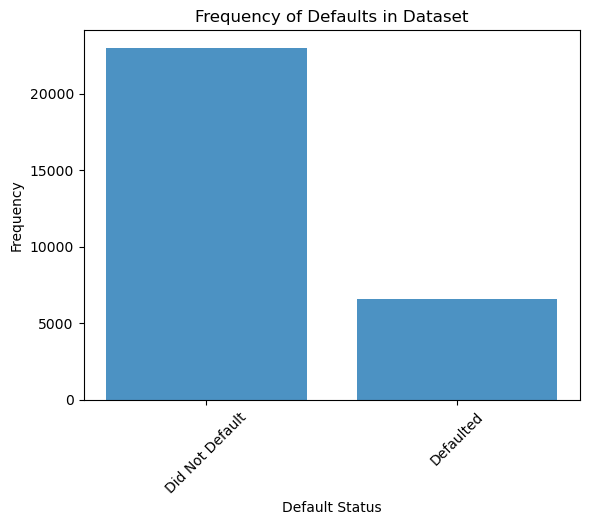

In [50]:
# Plot
plt.bar(default_counts_pandas['default_label'], default_counts_pandas['count'], alpha=0.8)
plt.title('Frequency of Defaults in Dataset')
plt.ylabel('Frequency')
plt.xlabel('Default Status')
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.show()

In [51]:
#Split daat in train and test as 70:30 ratio
(train_Data, test_Data) = data.randomSplit([0.7, 0.3], seed=12345)

In [52]:
train_Data.count()

20523

In [53]:
test_Data.count()

9078

## Step 5: Machine Learning Models

In [54]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import NaiveBayes, NaiveBayesModel
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')
from pyspark.sql.functions import when, col, lit
from pyspark.sql.types import FloatType
from pyspark.sql.types import StructType, StructField, StringType, FloatType

In [55]:
# Define the schema
performance_schema = StructType([
    StructField("Model", StringType(), True),
    StructField("Accuracy", FloatType(), True),
    StructField("Precision", FloatType(), True),
    StructField("Recall", FloatType(), True),
    StructField("F1", FloatType(), True)
])


In [56]:
# Create an empty DataFrame with the defined schema
performance = spark.createDataFrame([], schema=performance_schema)

### 5.1 Decision Tree

In [57]:
#Create the Decision Trees model
dt = DecisionTreeClassifier(labelCol="indexed", \
                featuresCol="scaled_features")

In [58]:
dt_Mod = dt.fit(train_Data)

In [59]:
#Predict on the test data
predict = dt_Mod.transform(test_Data)
predict.select("prediction","indexed","default_label","scaled_features").show(5)

+----------+-------+-------------+--------------------+
|prediction|indexed|default_label|     scaled_features|
+----------+-------+-------------+--------------------+
|       0.0|    0.0|          0.0|[2.02490488236881...|
|       0.0|    0.0|          0.0|[2.02490488236881...|
|       0.0|    0.0|          0.0|[2.02490488236881...|
|       0.0|    0.0|          0.0|[2.02490488236881...|
|       0.0|    0.0|          0.0|[2.02490488236881...|
+----------+-------+-------------+--------------------+
only showing top 5 rows



In [60]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="indexed", predictionCol="prediction")
accuracy = evaluator.evaluate(predict, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predict, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predict, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predict, {evaluator.metricName: "f1"})

In [61]:
# Add the performance metrics to the DataFrame
newRow = spark.createDataFrame([("Decision Tree", accuracy, precision, recall, f1)], schema=performance_schema)
performance = performance.union(newRow)

In [62]:
performance.show()

+-------------+----------+---------+----------+---------+
|        Model|  Accuracy|Precision|    Recall|       F1|
+-------------+----------+---------+----------+---------+
|Decision Tree|0.78398323|0.7523158|0.78398323|0.7347263|
+-------------+----------+---------+----------+---------+



In [63]:
# Calculate confusion matrix
confusion_matrix_dt = predict.groupBy('indexed').pivot('prediction', [0, 1]).count()

In [64]:
# Display confusion matrix
confusion_matrix_dt.show()

+-------+----+---+
|indexed|   0|  1|
+-------+----+---+
|    0.0|6754|239|
|    1.0|1722|363|
+-------+----+---+



### 5.2 Random Forest Model

In [65]:
#Create the Random Forest model
rf_classifier = RandomForestClassifier(labelCol="indexed", \
                featuresCol="scaled_features")
rf_Model = rf_classifier.fit(train_Data)

In [66]:
#Predict on the test data
predict = rf_Model.transform(test_Data)
predict.select("prediction","indexed","default_label","scaled_features").show(5)

+----------+-------+-------------+--------------------+
|prediction|indexed|default_label|     scaled_features|
+----------+-------+-------------+--------------------+
|       0.0|    0.0|          0.0|[2.02490488236881...|
|       0.0|    0.0|          0.0|[2.02490488236881...|
|       0.0|    0.0|          0.0|[2.02490488236881...|
|       0.0|    0.0|          0.0|[2.02490488236881...|
|       0.0|    0.0|          0.0|[2.02490488236881...|
+----------+-------+-------------+--------------------+
only showing top 5 rows



In [67]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="indexed", predictionCol="prediction")
accuracy = evaluator.evaluate(predict, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predict, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predict, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predict, {evaluator.metricName: "f1"})

In [68]:
# Add the performance metrics to the DataFrame
newRow = spark.createDataFrame([("Random Forest", accuracy, precision, recall, f1)], schema=performance_schema)
performance = performance.union(newRow)

In [69]:
performance.show()

+-------------+----------+----------+----------+---------+
|        Model|  Accuracy| Precision|    Recall|       F1|
+-------------+----------+----------+----------+---------+
|Decision Tree|0.78398323| 0.7523158|0.78398323|0.7347263|
|Random Forest|0.77572155|0.74049866|0.77572155|0.6987531|
+-------------+----------+----------+----------+---------+



In [70]:
# Calculate confusion matrix
confusion_matrix_rf = predict.groupBy('indexed').pivot('prediction', [0, 1]).count()

In [71]:
# Display confusion matrix
confusion_matrix_rf.show()

+-------+----+---+
|indexed|   0|  1|
+-------+----+---+
|    0.0|6904| 89|
|    1.0|1947|138|
+-------+----+---+



### 5.3 Naive Bayes Model

In [72]:
#Create the Naive Bayes model
nb = NaiveBayes(labelCol="indexed", \
                featuresCol="scaled_features")
nb_mod = nb.fit(train_Data)

In [73]:
#Predict on the test data
predict = nb_mod.transform(test_Data)
predict.select("prediction","indexed","default_label","scaled_features")

DataFrame[prediction: double, indexed: double, default_label: double, scaled_features: vector]

In [74]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="indexed", predictionCol="prediction")
accuracy = evaluator.evaluate(predict, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predict, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predict, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predict, {evaluator.metricName: "f1"})

In [75]:
# Add the performance metrics to the DataFrame
newRow = spark.createDataFrame([("Naive Bayes", accuracy, precision, recall, f1)], schema=performance_schema)
performance = performance.union(newRow)

In [76]:
# Calculate confusion matrix
confusion_matrix_nb = predict.groupBy('indexed').pivot('prediction', [0, 1]).count()

In [77]:
# Display confusion matrix
confusion_matrix_nb.show()

+-------+----+---+
|indexed|   0|  1|
+-------+----+---+
|    0.0|6889|104|
|    1.0|1951|134|
+-------+----+---+



### 5.4 SVC Classifier

In [78]:
svc = LinearSVC(labelCol='indexed',
                featuresCol= "scaled_features")
svc_model = svc.fit(train_Data)

In [79]:
#Predict on the test data
predict = svc_model.transform(test_Data)
predict.select("prediction","indexed","default_label","scaled_features")

DataFrame[prediction: double, indexed: double, default_label: double, scaled_features: vector]

In [80]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="indexed", predictionCol="prediction")
accuracy = evaluator.evaluate(predict, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predict, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predict, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predict, {evaluator.metricName: "f1"})

In [81]:
# Add the performance metrics to the DataFrame
newRow = spark.createDataFrame([("SVC Classifier", accuracy, precision, recall, f1)], schema=performance_schema)
performance = performance.union(newRow)

In [82]:
# Calculate confusion matrix
confusion_matrix_svc = predict.groupBy('indexed').pivot('prediction', [0, 1]).count()

In [83]:
# Display confusion matrix
confusion_matrix_svc.show()

+-------+----+----+
|indexed|   0|   1|
+-------+----+----+
|    0.0|6993|NULL|
|    1.0|2085|NULL|
+-------+----+----+



### 5.5 MLP Classifier

In [84]:
input_neurons= len(train_Data.first().scaled_features)
layers = [input_neurons,24,18,2]

In [85]:
mpl = MultilayerPerceptronClassifier(labelCol='indexed',
                                     featuresCol= "scaled_features",
                                    layers = layers,
                                    seed=20)
mpl_model = mpl.fit(train_Data)

In [86]:
#Predict on the test data
predict = mpl_model.transform(test_Data)
predict.select("prediction","indexed","default_label","scaled_features")

DataFrame[prediction: double, indexed: double, default_label: double, scaled_features: vector]

In [87]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="indexed", predictionCol="prediction")
accuracy = evaluator.evaluate(predict, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predict, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predict, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predict, {evaluator.metricName: "f1"})

In [88]:
# Add the performance metrics to the DataFrame
newRow = spark.createDataFrame([("MLP Classifier", accuracy, precision, recall, f1)], schema=performance_schema)
performance = performance.union(newRow)

In [89]:
# Calculate confusion matrix
confusion_matrix_mlp = predict.groupBy('indexed').pivot('prediction', [0, 1]).count()

In [90]:
# Display confusion matrix
confusion_matrix_mlp.show()

+-------+----+---+
|indexed|   0|  1|
+-------+----+---+
|    0.0|6654|339|
|    1.0|1605|480|
+-------+----+---+



## Step 6: Model Evaluation
#### Metric Evaluation of the above machine learning models(accuracy, precision, recall, F1)

In [91]:
performance.show()

+--------------+----------+----------+----------+---------+
|         Model|  Accuracy| Precision|    Recall|       F1|
+--------------+----------+----------+----------+---------+
| Decision Tree|0.78398323| 0.7523158|0.78398323|0.7347263|
| Random Forest|0.77572155|0.74049866|0.77572155|0.6987531|
|   Naive Bayes|0.77362853| 0.7296258|0.77362853|0.6968391|
|SVC Classifier| 0.7703239|0.59339887| 0.7703239|0.6703845|
|MLP Classifier| 0.7858559| 0.7552329| 0.7858559|0.7480654|
+--------------+----------+----------+----------+---------+



## Step 7: Interpreting the best Classification Model

The performance metrics displayed above are pivotal for assessing the effectiveness of the various machine learning models used in predicting credit card defaulters. The metrics shown are:

* Accuracy: The proportion of total correct predictions (both true positives and true negatives) over all predictions.
* Precision: The proportion of true positive predictions over all positive predictions (the number of true positives divided by the sum of true positives and false positives).
* Recall: Also known as sensitivity, it measures the proportion of actual positives that were correctly identified (the number of true positives divided by the sum of true positives and false negatives).
* F1 Score: The harmonic mean of precision and recall, which provides a balance between the two metrics, especially in cases where there is an uneven class distribution.


### Selection of Metric in our case
For the business objective of predicting credit card defaulters, each metric provides a different lens on the model's performance:

Accuracy is less informative in this context, especially if the dataset is imbalanced (which is often the case in default prediction, as defaults are less common than non-defaults). High accuracy could be achieved by predicting 'No Default' for all cases, which would be misleading.

Precision would be crucial for a bank or financial institution since it measures the likelihood that a customer predicted as a defaulter is indeed a defaulter. High precision reduces the chance of incorrectly labeling a customer as at risk, which could damage the relationship with the customer.

Recall is also important because it measures how well the model identifies actual defaulters. A model with low recall might overlook too many high-risk customers, leading to financial losses for the institution.

F1 Score is often the most relevant metric in this situation, as it provides a balance between precision and recall. For credit default prediction, where both false positives (incorrectly labeling customers as defaulters) and false negatives (failing to identify actual defaulters) are costly mistakes, the F1 score serves as a single measure to gauge a model's balanced performance.

**Given the business objective of minimizing risk and offering assistance to at-risk customers, F1 score is the most appropriate metric to focus on. It ensures that the model doesn't overly prioritize precision over recall or vice versa.**

### Model Interpretation and Conclusion
**Based on the performance metrics, the MLP Classifier has the highest F1 score, suggesting that it has the best balance between precision and recall. While it is not the model with the highest accuracy, this is not the primary concern due to the reasons discussed above. The MLP Classifier seems to be the most suitable choice for identifying credit card defaulters, given the balance between not missing actual defaulters (high recall) and not wrongly classifying non-defaulters as defaulters (high precision).**

The Decision Tree model follows closely with a slightly lower F1 score but has the benefit of potentially better generalization due to its ensemble nature, which might be a consideration for deployment.

The SVC classifier model has the lowest F1 score, which suggests that it might not be capturing the complexities of the relationships in the data as effectively as the other models.

These models could potentially be improved with more feature engineering or hyperparameter tuning but as it stands, they are not the top performers.

In conclusion, considering the business objective and the balance between precision and recall required, the MLP Classifier should be the first model to consider for deployment in predicting credit card defaulters. However, one must also consider model interpretability, computational efficiency, and how the model would be integrated into the existing decision-making process within the institution. Other factors, such as model robustness and how it handles new or evolving patterns of credit default, should also be taken into account before finalizing the decision.

## Step 8: Best Model Result - MLP Classifier

### Perfomance 

In [92]:
## Performance
# Filter the performance DataFrame for the MLP Classifier model
mlp_performance = performance.filter(performance['Model'] == 'MLP Classifier')

# Show the performance metrics for MLP Classifier
mlp_performance.show(5)

+--------------+---------+---------+---------+---------+
|         Model| Accuracy|Precision|   Recall|       F1|
+--------------+---------+---------+---------+---------+
|MLP Classifier|0.7858559|0.7552329|0.7858559|0.7480654|
+--------------+---------+---------+---------+---------+



### Confusion Matrix

In [93]:
# Calculate confusion matrix
confusion_matrix_mlp = predict.groupBy('indexed').pivot('prediction', [0, 1]).count()

In [94]:
# Display confusion matrix
confusion_matrix_mlp.show()

+-------+----+---+
|indexed|   0|  1|
+-------+----+---+
|    0.0|6654|339|
|    1.0|1605|480|
+-------+----+---+



### AUC

In [95]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

AUC_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='indexed',metricName='areaUnderROC')
AUC = AUC_evaluator.evaluate(predict)

print(f"The area under the curve is {AUC:.2f}")

The area under the curve is 0.59


The AUC of the ROC is a measure of a model's ability to distinguish between classes. An AUC of 0.59 suggests that the model's ability to differentiate defaulters from non-defaulters is marginally better than random chance. In ideal scenarios, you want this number to be as close to 1 as possible, indicating strong predictive capabilities.

###  Area under the PR curve

In [96]:
PR_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='indexed',metricName='areaUnderPR')
PR = PR_evaluator.evaluate(predict)

print("The area under the PR curve is {}".format(PR))

The area under the PR curve is 0.44890333529679827


The area under the Precision-Recall curve represents the model's effectiveness in identifying positive instances (defaulters) when faced with a class imbalance. A score of 0.44 shows moderate performance, indicating that when the model predicts a default, it is correct about 44% of the time. Higher values are better, as they would mean the model is more precise and still able to capture a good proportion of actual positives.

In [97]:
## Stop the spark session
spark.stop()